# Tweets influencing Bitcoin

La idea es crear un modelo que dado un tweet pueda predecir su efecto en el precion del bitcoin. Las categorias son Positivo: aumenta el precio, Negativo: disminuye el precio, Neutral: no hay cambio en el precio.

Para esto usaremos un modelo de clasificacion.

In [33]:
!pip install langid
!pip install many-stop-words
!pip install emoji
import pandas as pd
import langid
import warnings
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from statistics import mode
import nltk
from nltk.corpus import stopwords
import many_stop_words
import emoji
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import ssl
from joblib import dump, load
warnings.filterwarnings('ignore')


## Perfilamiento

In [34]:
filename = "mbsa.csv"
datosO = pd.read_csv(filename)

In [35]:
datos = datosO.sample(n=12000)

In [36]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 11595545 to 512476
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       12000 non-null  object
 1   text       12000 non-null  object
 2   Sentiment  11487 non-null  object
dtypes: object(3)
memory usage: 375.0+ KB


### Eliminar nulos

In [37]:
datos = datos[datos['Sentiment'].notna()]

### Estadisticas del Tweet

In [38]:
datos['Conteo'] = [len(x) for x in datos['text']]
datos['Moda'] = [[mode([x for x in i.split(' ')])][0] for i in datos['text']]
datos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in datos['text']]
datos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in datos['text']]
datos.head()

,Date,text,Sentiment,Conteo,Moda,Max,Min
11595545,2019-07-26,$dylandavii99 https://t.co/KNMuW2rf2F,Negative,37,$dylandavii99,23,13
2932720,2018-08-03,@Bitcoin_Stats,Negative,14,@Bitcoin_Stats,14,14
5064400,2016-02-27,Making Bitcoin Theft Impossible With The Undo ...,Positive,278,Making,225,3
1281857,2019-05-12,235 días de mercado bajista en el #Bitcoin han...,Negative,150,días,8,2
18619146,2019-11-11,"CoinDesk: ""Interested in alpha strategies for ...",Negative,272,strategies,11,2


### Hashtags, menciones y vinculos

In [39]:
def tagsMensUrls(x):
    x = str(x)
    x = x.replace('\n',' ')
    x = x.replace('(',' ')
    x = x.replace(')',' ')
    x = x.replace('\'','')
    return x.count(' #'), x.count(' @'),x.count('http'), (tags:=bus(x,'#')), (ment:=bus(x,'@')), newText(x,tags,ment)
def bus(x,a):
    l = []
    for y in x.split(' '):
        if (y.startswith(a)):
            l.append(y[1:].lower())
    return l
def newText(x,tags,ment):
    x = x.lower()
    for t in tags:
        x = x.replace("#"+t,"")
    for m in ment:
        x = x.replace("@"+m,"")
    for u in bus(x,"http"):
        x = x.replace('h'+u,"")
    return x
        
tagsMensUrlsInfo = pd.DataFrame(datos["text"].apply(tagsMensUrls).tolist(),columns=["Ntags","Nmentions","Nurls","tags","mentions","newText"],index=datos.index)
datos = pd.concat([datos, tagsMensUrlsInfo], axis=1)
datos.head()

,Date,text,Sentiment,Conteo,Moda,Max,Min,Ntags,Nmentions,Nurls,tags,mentions,newText
11595545,2019-07-26,$dylandavii99 https://t.co/KNMuW2rf2F,Negative,37,$dylandavii99,23,13,0,0,1,[],[],$dylandavii99
2932720,2018-08-03,@Bitcoin_Stats,Negative,14,@Bitcoin_Stats,14,14,0,0,0,[],[bitcoin_stats],
5064400,2016-02-27,Making Bitcoin Theft Impossible With The Undo ...,Positive,278,Making,225,3,0,0,2,[],[],making bitcoin theft impossible with the undo ...
1281857,2019-05-12,235 días de mercado bajista en el #Bitcoin han...,Negative,150,días,8,2,1,0,0,[bitcoin],[],235 días de mercado bajista en el han sido bo...
18619146,2019-11-11,"CoinDesk: ""Interested in alpha strategies for ...",Negative,272,strategies,11,2,1,0,0,[investnyc],[],"coindesk: ""interested in alpha strategies for ..."


### Encontrar idiomas

In [40]:
# datos["lang"]=datos["newText"].apply(lambda x: langid.classify(x)[0])
# plt.style.use('dark_background')
# fig=plt.figure(figsize=(21,4))
# n,b,p=plt.hist(datos["lang"])
# plt.title("Idiomas")
# datos['lang'].value_counts()

### Usar solo 10 idiomas mas relevantes

In [41]:
# languages = datos['lang'].value_counts().index.values[:10]
# datos = datos.loc[datos['lang'].isin(languages)]

### Ajustar sentimiento

In [42]:
patternP = re.compile("^(\s|\t)*(p|P)(\s|[A-Za-z])*$")
patternN = re.compile("^(\s|\t)*(neg|Neg)(\s|[A-Za-z])*$")
patternNeu = re.compile("^(\s|\t)*(neu|Neu)(\s|[A-Za-z])*$")
patternNumb = re.compile("^(\s|\t|[A-Za-z])*([0-9])+(\s|\t|[A-Za-z])*$")
datos.loc[[True if patternP.fullmatch(datos['Sentiment'][x]) is not None else False for x in datos.index], 'Sentiment'] = "Positive"
datos.loc[[True if patternN.fullmatch(datos['Sentiment'][x]) is not None else False for x in datos.index], 'Sentiment'] = "Negative"
datos.loc[[True if patternNeu.fullmatch(datos['Sentiment'][x]) is not None else False for x in datos.index], 'Sentiment'] = "Neutral"
datos = datos.drop(datos[[True if patternNumb.fullmatch(datos['Sentiment'][x]) is not None else False for x in datos.index]].index)

### Visualizar datos

Text(0.5, 1.0, 'Sentiment')

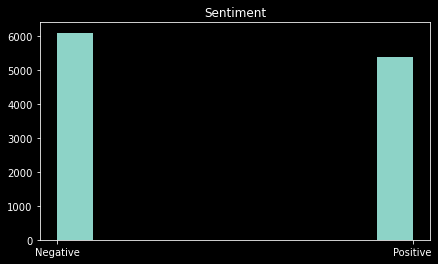

In [43]:
plt.style.use('dark_background')
fig=plt.figure(figsize=(7,4))
a = datos["Sentiment"].copy()
a[pd.isnull(a)]="Sin especificar"
plt.hist(a)
plt.title("Sentiment")

### Encoders

In [44]:
le = LabelEncoder()
le.fit(["Positive", "Negative", "Neutral"])
datos["Sentiment"] = le.transform(datos["Sentiment"])
le.classes_

array(['Negative', 'Neutral', 'Positive'], dtype='<U8')

### Fechas

In [45]:
datos["Date"]=pd.to_datetime(datos["Date"])
datos["year"] = datos["Date"].dt.year
datos["month"] = datos["Date"].dt.month
datos["day"] = datos["Date"].dt.day

In [46]:
datos.head()

,Date,text,Sentiment,Conteo,Moda,Max,Min,Ntags,Nmentions,Nurls,tags,mentions,newText,year,month,day
11595545,2019-07-26,$dylandavii99 https://t.co/KNMuW2rf2F,0,37,$dylandavii99,23,13,0,0,1,[],[],$dylandavii99,2019,7,26
2932720,2018-08-03,@Bitcoin_Stats,0,14,@Bitcoin_Stats,14,14,0,0,0,[],[bitcoin_stats],,2018,8,3
5064400,2016-02-27,Making Bitcoin Theft Impossible With The Undo ...,2,278,Making,225,3,0,0,2,[],[],making bitcoin theft impossible with the undo ...,2016,2,27
1281857,2019-05-12,235 días de mercado bajista en el #Bitcoin han...,0,150,días,8,2,1,0,0,[bitcoin],[],235 días de mercado bajista en el han sido bo...,2019,5,12
18619146,2019-11-11,"CoinDesk: ""Interested in alpha strategies for ...",0,272,strategies,11,2,1,0,0,[investnyc],[],"coindesk: ""interested in alpha strategies for ...",2019,11,11


### Traducir

In [47]:
# for l in languages:
#     translator= Translator(to_lang='en', from_lang=l)
#     datos.loc[datos['lang']==l]['newText'] = datos.loc[datos['lang']==l]['newText'].apply(lambda x: translator.translate(x))

In [48]:
# translator= Translator(to_lang='en', from_lang='ja')
# a = datos.loc[datos['lang']=='ja']['newText'].iloc[0]
# translator.translate(a)

In [49]:
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context
# nltk.download('stopwords')

### StopWords

In [50]:
languages = ['ar',
  'ca',
  'cs',
  'de',
  'el',
  'en',
  'es',
  'fi',
  'fr',
  'hu',
  'it',
  'ja',
  'kr',
  'nl',
  'no',
  'pl',
  'pt',
  'ru',
  'sk',
  'sv',
  'tr',
  'zh']

stop_words = []
for i in languages:
    stop_words = stop_words + list(many_stop_words.get_stop_words(i))
stop_words.append('\'')
stop_words.append('`')
stop_words.append('’')
stop_words.append('‘')

In [51]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/diego/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [52]:
ps = PorterStemmer()
corpus = []
stemmed_phrase = []
for i in datos["newText"]:
    new = emoji.get_emoji_regexp().sub(" ", i)
    new = new.lower()
    new = nltk.word_tokenize(new)
    stemmed = [ps.stem(i) for i in new if i not in stop_words]
    stemmed = ' '.join(stemmed)
    corpus.append(new)
    stemmed_phrase.append(stemmed)
    
datos["Tokens"] = corpus
datos["Stemmed"] = stemmed_phrase


In [53]:
datos["TagsText"] = datos["tags"].apply(lambda x: ' '.join(map(str, x)))
datos["MentionsText"] = datos["mentions"].apply(lambda x: ' '.join(map(str, x)))

In [54]:
datos.head(10)

,Date,text,Sentiment,Conteo,Moda,Max,Min,Ntags,Nmentions,Nurls,tags,mentions,newText,year,month,day,Tokens,Stemmed,TagsText,MentionsText
11595545,2019-07-26,$dylandavii99 https://t.co/KNMuW2rf2F,0,37,$dylandavii99,23,13,0,0,1,[],[],$dylandavii99,2019,7,26,"[$, dylandavii99]",$ dylandavii99,,
2932720,2018-08-03,@Bitcoin_Stats,0,14,@Bitcoin_Stats,14,14,0,0,0,[],[bitcoin_stats],,2018,8,3,[],,,bitcoin_stats
5064400,2016-02-27,Making Bitcoin Theft Impossible With The Undo ...,2,278,Making,225,3,0,0,2,[],[],making bitcoin theft impossible with the undo ...,2016,2,27,"[making, bitcoin, theft, impossible, with, the...",make bitcoin theft imposs undo button,,
1281857,2019-05-12,235 días de mercado bajista en el #Bitcoin han...,0,150,días,8,2,1,0,0,[bitcoin],[],235 días de mercado bajista en el han sido bo...,2019,5,12,"[235, días, de, mercado, bajista, en, el, han,...",235 día mercado bajista borrado último 40 día ...,bitcoin,
18619146,2019-11-11,"CoinDesk: ""Interested in alpha strategies for ...",0,272,strategies,11,2,1,0,0,[investnyc],[],"coindesk: ""interested in alpha strategies for ...",2019,11,11,"[coindesk, :, ``, interested, in, alpha, strat...",coindesk : `` interest alpha strategi 2020 ? t...,investnyc,
9119246,2019-07-06,The Paxful community is evolving crypto securi...,2,225,Paxful,11,1,2,0,0,"[kenya, p2pfinance]",[],the paxful community is evolving crypto securi...,2019,7,6,"[the, paxful, community, is, evolving, crypto,...",pax commun evolv crypto secur individu level ....,kenya p2pfinance,
13683018,2019-08-25,The latest The blockchain fintech Daily! https...,0,117,The,23,2,2,2,1,"[bitcoin, ai]","[therudingroup, lord_ssemanda]",the latest the blockchain fintech daily! than...,2019,8,25,"[the, latest, the, blockchain, fintech, daily,...",latest blockchain fintech daili !,bitcoin ai,therudingroup lord_ssemanda
3104350,2018-08-03,@Bitcoin_price_8,0,16,@Bitcoin_price_8,16,16,0,0,0,[],[bitcoin_price_8],,2018,8,3,[],,,bitcoin_price_8
1755189,2017-10-11,#Putin Tells Central Bank Not to Create Barri...,2,70,to,17,0,1,0,0,"[putin, cryptocurrencies]",[],tells central bank not to create barriers to,2017,10,11,"[tells, central, bank, not, to, create, barrie...",tell central bank creat barrier,putin cryptocurrencies,
13786512,2019-08-27,VMWare CEO Gelsinger Condemns #Bitcoin as Bad ...,0,95,Bad,33,2,1,0,1,[bitcoin],[],"vmware ceo gelsinger condemns as bad design, ...",2019,8,27,"[vmware, ceo, gelsinger, condemns, as, bad, de...","vmware ceo gelsing condemn bad , bad human",bitcoin,


In [55]:
# pasar a csv antes de vectorizar
datos.to_csv('antes_vecorizer.csv')

In [56]:
stemmed_data = datos["Stemmed"] 

In [57]:
stemmed_text_vectorizer = TfidfVectorizer(binary=True)
stemmed_data = stemmed_text_vectorizer.fit_transform(datos["Stemmed"] )
print(stemmed_data.shape)
df_stemmed = pd.DataFrame(stemmed_data.toarray())

(11487, 21874)


In [58]:
tags_text_vectorizer = CountVectorizer(binary=True)
tags_data = tags_text_vectorizer.fit_transform(datos["TagsText"])
print(tags_data.shape)
df_tags = pd.DataFrame(tags_data.toarray())

(11487, 5120)


In [59]:
mentions_text_vectorizer = CountVectorizer(binary=True)
mentions_data = tags_text_vectorizer.fit_transform(datos["MentionsText"])
print(mentions_data.shape)
df_mentions = pd.DataFrame(mentions_data.toarray())

(11487, 3224)


In [60]:
# Se concatenan todas las columnas con datos numéricos
X = pd.concat([datos[["Conteo", "Max", "Min", "Ntags", "Nmentions", "Nurls", "year", "month", "day"]].reset_index(drop=True), df_tags, df_mentions], axis=1)
Y = datos["Sentiment"].reset_index(drop=True)

In [61]:
X

,Conteo,Max,Min,Ntags,Nmentions,Nurls,year,month,day,0,...,3214,3215,3216,3217,3218,3219,3220,3221,3222,3223
0,37,23,13,0,0,1,2019,7,26,0,...,0,0,0,0,0,0,0,0,0,0
1,14,14,14,0,0,0,2018,8,3,0,...,0,0,0,0,0,0,0,0,0,0
2,278,225,3,0,0,2,2016,2,27,0,...,0,0,0,0,0,0,0,0,0,0
3,150,8,2,1,0,0,2019,5,12,0,...,0,0,0,0,0,0,0,0,0,0
4,272,11,2,1,0,0,2019,11,11,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11482,119,12,1,0,0,0,2019,9,7,0,...,0,0,0,0,0,0,0,0,0,0
11483,177,13,0,0,0,0,2019,7,3,0,...,0,0,0,0,0,0,0,0,0,0
11484,14,14,14,0,0,0,2018,8,3,0,...,0,0,0,0,0,0,0,0,0,0
11485,234,16,1,0,0,0,2019,10,26,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
Y

0        0
1        0
2        2
3        0
4        0
        ..
11482    2
11483    2
11484    0
11485    2
11486    2
Name: Sentiment, Length: 11487, dtype: int64

In [63]:
# despues de vectorizar
# x vectorizado
X.to_csv("x_vectorizado.csv")
Y.to_csv("y_vectorizado.csv")

## Construcción de modelos

## Arbol de decisión

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [65]:
arbol = DecisionTreeClassifier(random_state=0)

In [66]:
arbol = arbol.fit(X_train, Y_train)

In [67]:
y_pred = arbol.predict(X_test)

In [68]:
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test, y_pred, average='weighted')))
print("Precisión: {}".format(precision_score(Y_test,y_pred, average='weighted')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred, average='weighted')))

Exactitud: 0.96
Recall: 0.9550333623440673
Precisión: 0.9550349434017483
Puntuación F1: 0.9550276265640366


In [69]:
# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[4,6,8,10,20],'min_samples_split':[2, 3, 4, 5]}

In [70]:
# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol = DecisionTreeClassifier(random_state=0)

In [71]:
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
# Ajuste del modelo
mejor_modelo.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 20],
                         'min_samples_split': [2, 3, 4, 5]})

In [72]:
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
mejor_modelo.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 4}

In [73]:
y_pred = mejor_modelo.predict(X_test)
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test, y_pred, average='weighted')))
print("Precisión: {}".format(precision_score(Y_test,y_pred, average='weighted')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred, average='weighted')))

Exactitud: 0.95
Recall: 0.9527125036263417
Precisión: 0.952917811503575
Puntuación F1: 0.9526797588429843


In [74]:
arbol_final = mejor_modelo.best_estimator_

In [75]:
 # Usamos la lbreria joblib
filename = 'arbol.joblib'
# Se guarda
dump(arbol_final, filename)

['arbol.joblib']

In [76]:
importancia= mejor_modelo.best_estimator_.feature_importances_
importancia

array([0.04379902, 0.00732548, 0.02134719, ..., 0.        , 0.        ,
       0.        ])

In [77]:
# Se obtiene la importancia de cada uno de los atributos para el resultado del mejor modelo
importancia_atributo = pd.DataFrame(data={"Atributo": X_train.columns,"Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo.head()

,Atributo,Importancia
0,day,0.543236
1,month,0.255540
2,year,0.105912
3,Conteo,0.043799
4,Min,0.021347


In [78]:
importancia_atributo.head(15)

,Atributo,Importancia
0,day,0.543236
1,month,0.255540
2,year,0.105912
3,Conteo,0.043799
4,Min,0.021347
5,Max,0.007325
6,Ntags,0.004286
7,572,0.002539
8,2641,0.001791
9,4891,0.001044


## KNN

In [79]:
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)

In [80]:
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test, y_pred, average='weighted')))
print("Precisión: {}".format(precision_score(Y_test,y_pred, average='weighted')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred, average='weighted')))

Exactitud: 0.59
Recall: 0.5857267188859878
Precisión: 0.5848975789828091
Puntuación F1: 0.5848185576502105


In [81]:
# Búsqueda de hiper parámetros en KNN
# Lista de Hiperparámetros a afinar
n_neighbors = list(range(1,20))
n_odd_neighbors = list(filter(lambda x: (x % 2 != 0), n_neighbors))
p=[1,2] #Función de distancia 1: manhattan, 2: euclidean, otro valor: minkowski

#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p)

#Create new KNN object
knn_2 = KNeighborsClassifier()

In [82]:
#Usamos GridSearch
mejor_modelo_knn = GridSearchCV(knn_2, hyperparameters, cv=10)

#Fit the model
mejor_modelo_knn.fit(X_train, Y_train)

# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
print('Best p:', mejor_modelo_knn.best_estimator_.get_params()['p'])
print('Best n_neighbors:', mejor_modelo_knn.best_estimator_.get_params()['n_neighbors'])
# Obtener el mejor modelo.
neigh_final = mejor_modelo_knn.best_estimator_

Best p: 1
Best n_neighbors: 6


In [83]:
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
neigh_final

KNeighborsClassifier(n_neighbors=6, p=1)

In [84]:
#Estadisticas con el conjunto de prueba
y_pred = neigh_final.predict(X_test)
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test, y_pred, average='weighted')))
print("Precisión: {}".format(precision_score(Y_test,y_pred, average='weighted')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred, average='weighted')))

Exactitud: 0.59
Recall: 0.591238758340586
Precisión: 0.5960684310299029
Puntuación F1: 0.5755338717422631


## Random Forest

In [85]:
forest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, max_depth=2)
forest = forest.fit(X_train, Y_train)

In [86]:
y_pred = forest.predict(X_test)
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test, y_pred, average='weighted')))
print("Precisión: {}".format(precision_score(Y_test,y_pred, average='weighted')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred, average='weighted')))

Exactitud: 0.52
Recall: 0.5230635335073978
Precisión: 0.2735954600852446
Puntuación F1: 0.35926992415765263


In [87]:
# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'n_estimators':[50, 100, 200],'criterion':['gini', 'entropy'],'max_depth':[None,4,10,20],'min_samples_split':[4, 10, 20]}

In [88]:
forest = RandomForestClassifier()
# Se comprueban los mejores hiperparametros
mejor_modelo = GridSearchCV(forest, param_grid, cv=particiones)
# Ajuste del modelo
mejor_modelo.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 4, 10, 20],
                         'min_samples_split': [4, 10, 20],
                         'n_estimators': [50, 100, 200]})

In [89]:
mejor_modelo.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_split': 4,
 'n_estimators': 200}

In [90]:
y_pred = mejor_modelo.predict(X_test)
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test, y_pred, average='weighted')))
print("Precisión: {}".format(precision_score(Y_test,y_pred, average='weighted')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred, average='weighted')))

Exactitud: 0.74
Recall: 0.7409341456338845
Precisión: 0.7419007722135292
Puntuación F1: 0.7398222503808954


In [91]:
 # Usamos la lbreria joblib
filename = 'rf.joblib'
# Se guarda
dump(mejor_modelo.best_estimator_, filename)

['rf.joblib']

In [92]:
 # Usamos la lbreria joblib
filename = 'knn.joblib'
# Se guarda
dump(neigh_final, filename)

['knn.joblib']